# This notebook was used for generating some key figures for the Pf8 manuscript

In [1]:
# Import packages and initialise key dataframes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import combinations
from scipy.stats import fisher_exact
from tqdm import tqdm

cnv_df = pd.read_csv("20250130_full_cnv_data_pf8.tsv", sep = "\t")

pf8_meta = pd.read_csv("../assets_pf8/Pf_8_samples_20241212.txt", sep = "\t",
                       usecols = ["Sample", "Study", "Admin level 1", "Country", "Year", "Population", "% callable" , "Sample type", "Sample was in Pf7", "QC pass"])
pf8_meta["Pf_release"] = pf8_meta["Sample was in Pf7"].map({True: "Pf7", False: "Pf8"})
pf8_meta = pf8_meta.loc[pf8_meta["QC pass"] == True].reset_index(drop = True)
pf8_meta["Year group"] = pf8_meta.Year.apply(lambda x: 3 * (x // 3)).apply(lambda x: f"{int(x)} - {int(x) + 2}")

merge_df = cnv_df.merge(pf8_meta, on = "Sample").drop(columns = ["Sample was in Pf7"]).astype({"Year": int})

merge_df["n_missing"] = (merge_df[[col for col in merge_df if col.endswith("_final_amplification_call")]] == -1).sum(axis = 1)

merge_df.head(3)

,Sample,CRT_uncurated_coverage_only,CRT_curated_coverage_only,CRT_breakpoint,CRT_faceaway_only,CRT_final_amplification_call,GCH1_uncurated_coverage_only,GCH1_curated_coverage_only,GCH1_breakpoint,GCH1_faceaway_only,...,Country,Admin level 1,Year,Population,% callable,QC pass,Sample type,Pf_release,Year group,n_missing
0,FP0008-C,0,0,-,-1,0,-1,-1,-,0,...,Mauritania,Hodh el Gharbi,2014,AF-W,82.48,True,gDNA,Pf7,2013 - 2015,0
1,FP0009-C,0,0,-,0,0,0,0,-,0,...,Mauritania,Hodh el Gharbi,2014,AF-W,88.95,True,gDNA,Pf7,2013 - 2015,0
2,FP0010-CW,-1,-1,-,0,0,-1,-1,-,0,...,Mauritania,Hodh el Gharbi,2014,AF-W,87.01,True,sWGA,Pf7,2013 - 2015,0


In [2]:
# Sanity check distribution of final CNV calls
for cnv_call in ["HRP2_final_deletion_call", "CRT_final_amplification_call",
                 "HRP3_final_deletion_call", "MDR1_final_amplification_call",
                 "PM2_PM3_final_amplification_call", "GCH1_final_amplification_call"]:
    print(merge_df[cnv_call].value_counts())

HRP2_final_deletion_call
 0    13512
-1    10882
 1       15
Name: count, dtype: int64
CRT_final_amplification_call
 0    22321
-1     2002
 1       86
Name: count, dtype: int64
HRP3_final_deletion_call
 0    13120
-1    11074
 1      215
Name: count, dtype: int64
MDR1_final_amplification_call
 0    19512
-1     4195
 1      702
Name: count, dtype: int64
PM2_PM3_final_amplification_call
 0    17610
-1     4719
 1     2080
Name: count, dtype: int64
GCH1_final_amplification_call
 0    17631
-1     4134
 1     2644
Name: count, dtype: int64


In [10]:
# Double-check the confusion matrix for the CNV calls between Pf7 and Pf8

pf7_cnv = pd.read_csv("../04_gcnv_calls_validation/app_files/Pf7_inferred_resistance_status_classification.tsv", sep = "\t", usecols = ["Sample", "Mefloquine", "Piperaquine"]
                     ).rename(columns = {"Mefloquine": "pf7_MDR1", "Piperaquine": "pf7_PM2_PM3"})
pf7_cnv[["pf7_MDR1", "pf7_PM2_PM3"]] = pf7_cnv[["pf7_MDR1", "pf7_PM2_PM3"]].map(lambda x: {
    "Sensitive": 0, "Resistant": 1, "Undetermined": -1
}[x])

pf7_inner_join = pf7_cnv.merge(merge_df, on = "Sample", how = "inner").reset_index(drop = True)

print(pf7_inner_join.groupby(["pf7_PM2_PM3", "PM2_PM3_final_amplification_call"]).size())
print("\n")

print("PM2_PM3 0 -> 1:", pf7_inner_join.loc[
    (pf7_inner_join.pf7_PM2_PM3 == 0) & (pf7_inner_join.PM2_PM3_final_amplification_call == 1), ["Sample", "PM2_PM3_curated_coverage_only", "PM2_PM3_faceaway_only"]].to_dict("records"))

print("PM2_PM3 1 -> 0:", pf7_inner_join.loc[
    (pf7_inner_join.pf7_PM2_PM3 == 1) & (pf7_inner_join.PM2_PM3_final_amplification_call == 0), ["Sample", "PM2_PM3_curated_coverage_only", "PM2_PM3_faceaway_only"]].to_dict("records"))

print("\n" * 3)

print(pf7_inner_join.groupby(["pf7_MDR1", "MDR1_final_amplification_call"]).size())
print("\n")

print("MDR1 0 -> 1:", pf7_inner_join.loc[
    (pf7_inner_join.pf7_MDR1 == 0) & (pf7_inner_join.MDR1_final_amplification_call == 1), ["Sample", "MDR1_curated_coverage_only", "MDR1_faceaway_only"]].to_dict("records"))

print("MDR1 1 -> 0:", pf7_inner_join.loc[
    (pf7_inner_join.pf7_MDR1 == 1) & (pf7_inner_join.MDR1_final_amplification_call == 0), ["Sample", "MDR1_curated_coverage_only", "MDR1_faceaway_only"]].to_dict("records"))

pf7_PM2_PM3  PM2_PM3_final_amplification_call
-1           -1                                   1446
              0                                     15
              1                                      1
 0           -1                                    346
              0                                  12923
              1                                      1
 1           -1                                      2
              0                                      1
              1                                   1264
dtype: int64


PM2_PM3 0 -> 1: [{'Sample': 'RCN12591', 'PM2_PM3_curated_coverage_only': -1, 'PM2_PM3_faceaway_only': 1}]
PM2_PM3 1 -> 0: [{'Sample': 'PH1205-C', 'PM2_PM3_curated_coverage_only': 0, 'PM2_PM3_faceaway_only': -1}]




pf7_MDR1  MDR1_final_amplification_call
-1        -1                                1351
           0                                  62
           1                                   4
 0        -1                             

# The above samples were manually inspected. They're well within an acceptable range of inconsistencies. So we will move on with the rest of the validation

Chiyun's messages from Slack: 

```
This sample was called -1 for HMM, but 1 for faceaway. For Pf7, the faceaway call was -1. This one could be plausible so happy to leave it as is, personally
[...]
This sample was called as 0 by HMM, but faceaway call was -1. For Pf7, the faceaway call was missing but the HMM genotyper called this as 1. I would consider calling this as missing
[...]
We're clearly in the right for this one. This was called as 0 for Pf7! A nice MDR1 triplication, which we successfully called as 1. (also seems our HMM normalised better than previously)
[...]
The remaining 1 -> 0 transitions are a similar story. HMM is missing, but faceaway reads calls them as 0, so it swings to GT=0. I'd consider modifying these to -1
```

### Richard and Chiyun agree these samples are good enough. 

---
---

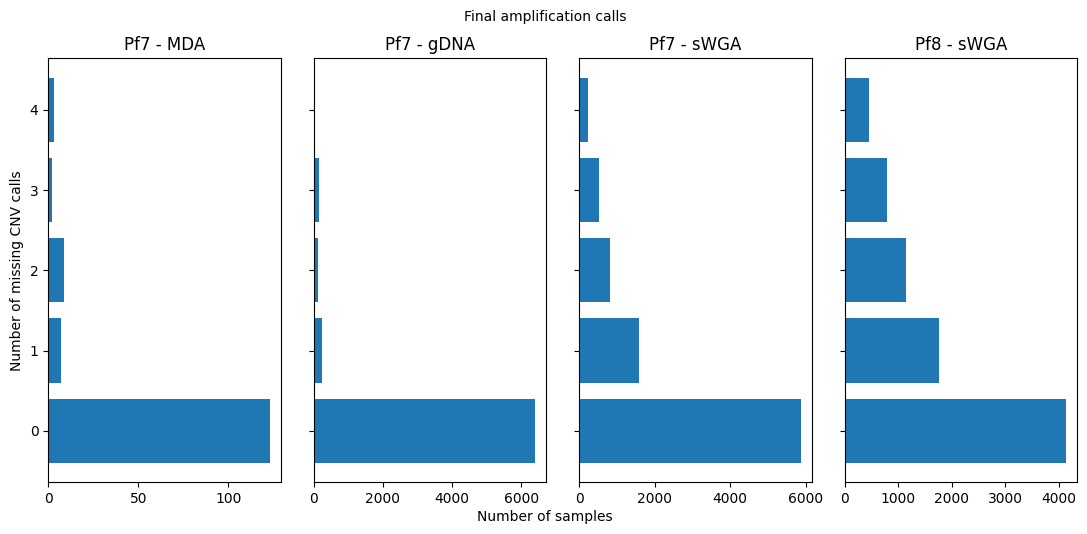

In [4]:
# Following plot was not used in the manuscript

plot_df = merge_df.groupby(["Pf_release", "Sample type"]).apply(lambda s: pd.Series({
    "n": len(s),
    "Mean": s.n_missing.mean(),
    "Stderror": s.n_missing.std(ddof=1) / np.sqrt(len(s)),
    "ValueCounts": np.unique(s.n_missing, return_counts=True)
}), include_groups=False).reset_index()

plot_df["ValueCounts"] = plot_df["ValueCounts"].apply(lambda x: dict(zip(x[0], x[1])))

fig, axes = plt.subplots(1, 4, figsize=(11, 5),
                         # sharex=True,
                         sharey=True)

for i, row in plot_df.iterrows():        
    axes[i].barh(
        list(row.ValueCounts.keys()),
        list(row.ValueCounts.values())
    )
    
    axes[i].set_title(f"{row.Pf_release} - {row['Sample type']}")

axes[0].set_ylabel("Number of missing CNV calls")
fig.text(s = "Number of samples",
         x = 0.5, y = 0, ha = "center")
fig.text(s = "Final amplification calls",
         x = 0.5, y = 1, ha = "center")
plt.tight_layout()
plt.show()

/tmp/ipykernel_709857/4031962663.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(by_population.index, rotation=30)
/tmp/ipykernel_709857/4031962663.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(by_population.index, rotation=30)
/tmp/ipykernel_709857/4031962663.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(by_population.index, rotation=30)
/tmp/ipykernel_709857/4031962663.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(by_population.index, rotation=30)
/tmp/ipykernel_709857/4031962663.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(by_population.index, rotation=30)
/tmp/ipykernel_709857/4031962663.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].

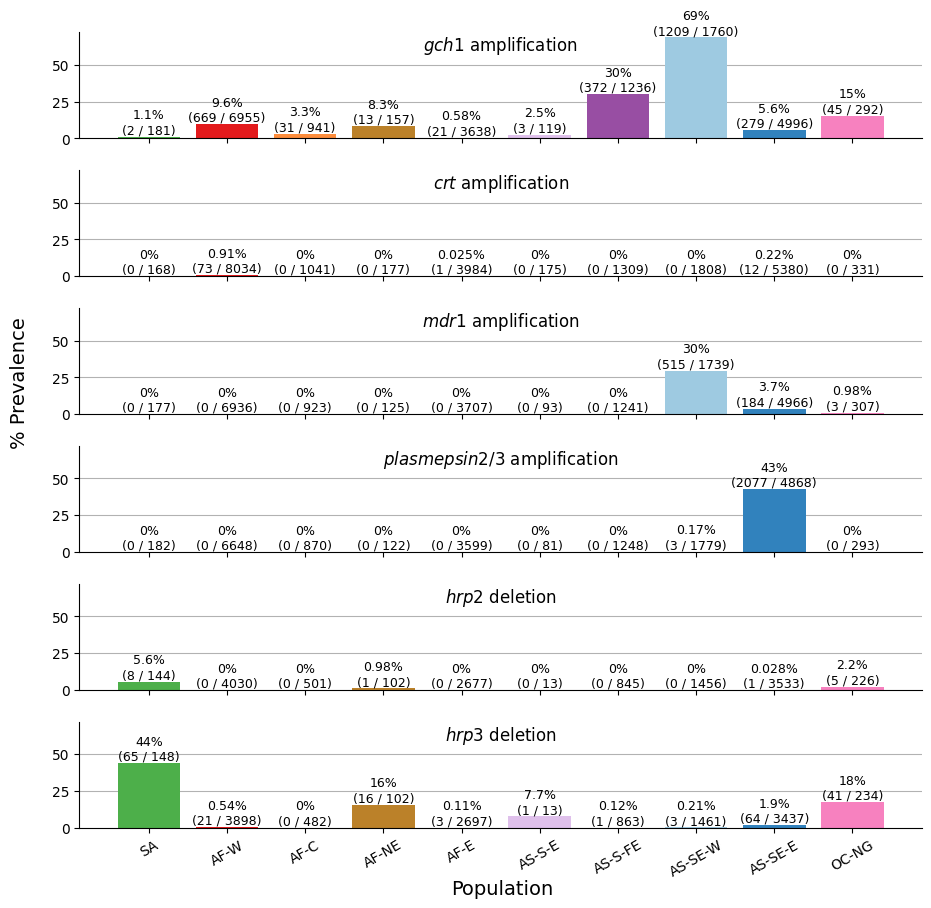

In [7]:
# The following plot is Figure 3 of the Pf8 manuscript

cnv_call_ids = {
    "GCH1_final_amplification_call": "$\it{gch1}$ amplification",
    "CRT_final_amplification_call": "$\it{crt}$ amplification",
    "MDR1_final_amplification_call": "$\it{mdr1}$ amplification",
    "PM2_PM3_final_amplification_call": "$\it{plasmepsin2/3}$ amplification",
    "HRP2_final_deletion_call": "$\it{hrp2}$ deletion",
    "HRP3_final_deletion_call": "$\it{hrp3}$ deletion",
}

population_colour_map = {
    'SA' : "#4daf4a",
    'AF-W' : "#e31a1c",
    'AF-C' : "#fd8d3c" ,
    'AF-NE' : "#bb8129" ,
    'AF-E' : "#fecc5c",
    'AS-S-E' : "#dfc0eb" ,
    'AS-S-FE' : "#984ea3" ,
    'AS-SE-W' : "#9ecae1",
    'AS-SE-E' : "#3182bd",
    'OC-NG' : "#f781bf"
}

fig, axes = plt.subplots(6, 1, figsize=(9, 9), sharex=True, sharey=True)
axes = axes.ravel()

for i, (gene, title) in enumerate(cnv_call_ids.items()):
    by_population = by_population = merge_df.groupby("Population")[gene].apply(
        lambda x: pd.DataFrame({
            "ratio": [sum(x == 1) / sum(x != -1)],
            "cnv_gt_1": [sum(x == 1)],
            "cnv_gt_0_1": [sum(x != -1)]
        })
    ).reset_index(level=1, drop=True)
    
    by_population.index = pd.Categorical(by_population.index, categories=list(population_colour_map.keys()), ordered=True)
    
    by_population = by_population.sort_index()
    
    bars = axes[i].bar(
        by_population.index, by_population["ratio"] * 100,
        color=[population_colour_map[pop] for pop in by_population.index]
    )
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2g}%\n({int(by_population['cnv_gt_1'].iloc[j])} / {int(by_population['cnv_gt_0_1'].iloc[j])})",
            ha="center", va="bottom", fontsize=9
        )

    axes[i].set_xticklabels(by_population.index, rotation=30)
    axes[i].set_title(title, y=0.75)
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)

    # Add horizontal reference lines
    for y in [25, 50]:
        axes[i].axhline(y=y, linewidth=0.8, color="black", alpha=0.3, zorder=-1)

# Add global labels
fig.text(s="% Prevalence", x=-0.03, y=0.5, rotation=90, fontsize=14)
fig.text(s="Population", x=0.46, y=0, fontsize=14)

plt.tight_layout()
fig.subplots_adjust(hspace=0.3)
plt.savefig("pf8-cnv-population-breakdown.png", dpi = 1200, bbox_inches="tight")
plt.show()


In [ ]:
# The following plots were not used in the Pf8 manuscript, but they contributed towards the development of the cell below it (which was Supplementary Figure 4)

def calculate_standard_error(s: pd.Series):
    p = s.ratio
    n = s.cnv_gt_0_1
    
    if n <= 1:
        return np.nan
    
    return np.sqrt(p * (1 - p) / n)

cnv_call_ids = {"HRP2_final_deletion_call": "HRP2 deletion",
                "CRT_final_amplification_call": "CRT amplification",
                "HRP3_final_deletion_call": "HRP3 deletion",
                "MDR1_final_amplification_call": "MDR1 amplification",
                "PM2_PM3_final_amplification_call": "PM2_PM3 amplification",
                "GCH1_final_amplification_call": "GCH1 amplification"}

# cnv_call_ids = {"HRP2_final_deletion_call": "HRP2 deletion",
#                 "CRT_faceaway_only": "CRT amplification - faceaway only",
#                 "HRP3_final_deletion_call": "HRP3 deletion",
#                 "MDR1_faceaway_only": "MDR1 amplification - faceaway only",
#                 "PM2_PM3_faceaway_only": "PM2_PM3 amplification - faceaway only",
#                 "GCH1_faceaway_only": "GCH1 amplification - faceaway only"}

# cnv_call_ids = {"HRP2_final_deletion_call": "HRP2 deletion",
#                 "CRT_curated_coverage_only": "CRT amplification - coverage only",
#                 "HRP3_final_deletion_call": "HRP3 deletion",
#                 "MDR1_curated_coverage_only": "MDR1 amplification - coverage only",
#                 "PM2_PM3_curated_coverage_only": "PM2_PM3 amplification - coverage only",
#                 "GCH1_curated_coverage_only": "GCH1 amplification - coverage only"}

population_colour_map = {
    'SA' : "#4daf4a",
    'AF-W' : "#e31a1c",
    'AF-C' : "#fd8d3c" ,
    'AF-NE' : "#bb8129" ,
    'AF-E' : "#fecc5c",
    'AS-S-E' : "#dfc0eb" ,
    'AS-S-FE' : "#984ea3" ,
    'AS-SE-W' : "#9ecae1",
    'AS-SE-E' : "#3182bd",
    'OC-NG' : "#f781bf"
}

for pop_of_interest, colour in population_colour_map.items():
    for gene_of_interest, title in cnv_call_ids.items():
        subset_df = merge_df.loc[
            (merge_df[gene_of_interest] != -1) &
            (merge_df.Population == pop_of_interest)
        ]
        
        longitudinal_data = subset_df.groupby("Year")[gene_of_interest].apply(lambda x: pd.Series({
            "ratio": sum(x == 1) / sum(x != -1),
            "cnv_gt_1": sum(x == 1),
            "cnv_gt_0_1": sum(x != -1)
        })).unstack().reset_index().astype({"Year": int, "cnv_gt_1": int, "cnv_gt_0_1": int})
        
        longitudinal_data = longitudinal_data.loc[longitudinal_data.cnv_gt_0_1 >= 25]
        
        if len(longitudinal_data) < 5:
            continue

        if longitudinal_data.ratio.sum() < 0.1:
            continue
            
        longitudinal_data["standard_error"] = longitudinal_data.apply(calculate_standard_error, axis = 1)
        
        fig, ax = plt.subplots(figsize = (7, 4))
        
        ax.errorbar(
            longitudinal_data.Year, longitudinal_data.ratio * 100,
            yerr = longitudinal_data.standard_error * 100,
            fmt = "o", capsize = 5, color = colour
        )
        ax.plot(
            longitudinal_data.Year, longitudinal_data.ratio * 100,
            color=colour, linestyle="-", marker="None"
        )

        for y in [0, 20, 40, 60, 80]:
            ax.axhline(y = y, linewidth = 0.5, alpha = 0.1, color = "black", zorder = -1)
            
        ax.set_title(f"{title} % prevalence (± S.E.) in {pop_of_interest}", y = 0.95)
        ax.set_xlabel("Year")
        ax.set_ylabel("% prevalence")
        ax.set_ylim(-5, 100)

        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.savefig(f"temporal-plots/temporal {title} {pop_of_interest}.png", dpi = 1200)
        plt.show()
        
        print(merge_df.loc[
            (merge_df[gene_of_interest] != -1) &
            (merge_df.Population == pop_of_interest)
        ].groupby("Year")[["Pf_release", "Sample type"]].value_counts())

    Year     ratio  cnv_gt_1  cnv_gt_0_1  standard_error
6   1984  0.000000         0         113        0.000000
10  2007  0.000000         0          81        0.000000
11  2008  0.029630         4         135        0.014594
12  2009  0.093220        11         118        0.026765
13  2010  0.120482        20         166        0.025266
14  2011  0.029167         7         240        0.010862
15  2012  0.049383         4          81        0.024074
16  2013  0.135220       129         954        0.011071
17  2014  0.073022        72         986        0.008286
18  2015  0.082645        50         605        0.011194
19  2016  0.075497        57         755        0.009615
20  2017  0.126270        87         689        0.012654
21  2018  0.116950       158        1351        0.008743
22  2019  0.068100        19         279        0.015082
23  2020  0.153595        47         306        0.020612
    Year     ratio  cnv_gt_1  cnv_gt_0_1  standard_error
0   2001  0.774194        24   

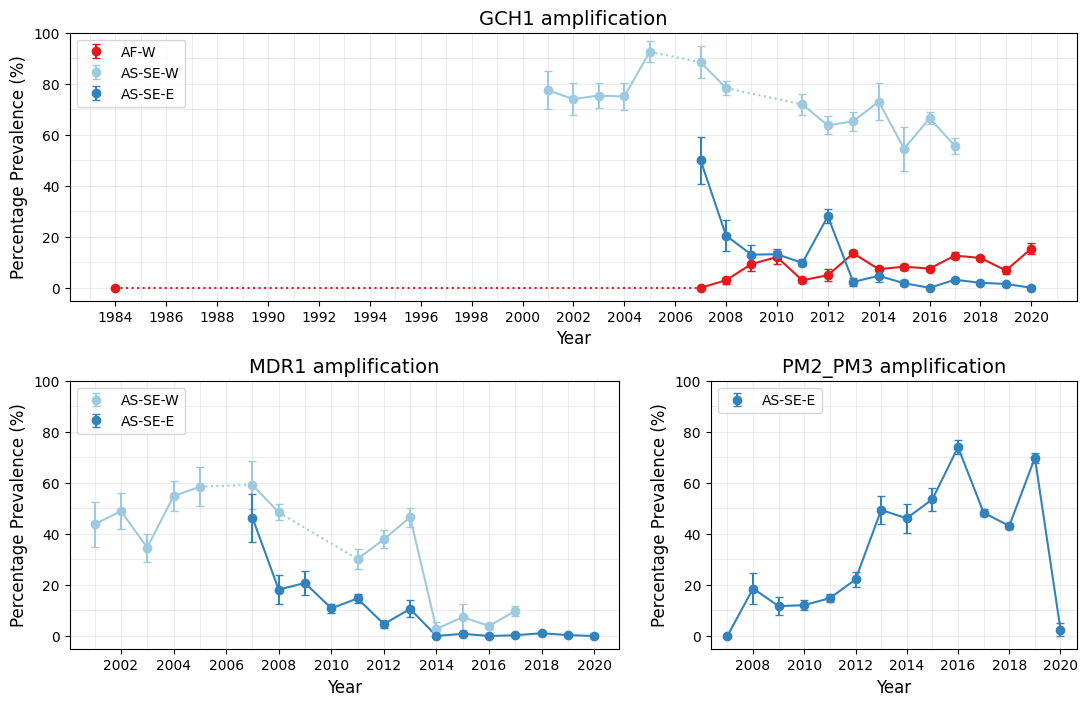

In [22]:
# A selection of temporal trends in CNV prevalence. This figure was Supplementary Figure 4

def calculate_standard_error(s: pd.Series):
    p = s.ratio
    n = s.cnv_gt_0_1
    
    if n <= 1:
        return np.nan
    
    return np.sqrt(p * (1 - p) / n)

x_tick_interval = 2
gap_threshold   = 1

fig = plt.figure(figsize = (13, 8))
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[3, 2])
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

plotting_data = [
    {
        "pop_of_interest"   : "AF-W",
        "pop_colour"        : "#e31a1c",
        "column_of_interest": "GCH1_final_amplification_call",
        "subplot_axis"      : ax1,
        "title"             : "GCH1 amplification",
    },
    {
        "pop_of_interest"   : "AS-SE-W",
        "pop_colour"        : "#9ecae1",
        "column_of_interest": "GCH1_final_amplification_call",
        "subplot_axis"      : ax1,
        "title"             : "GCH1 amplification",
    },
    {
        "pop_of_interest"   : "AS-SE-E",
        "pop_colour"        : "#3182bd",
        "column_of_interest": "GCH1_final_amplification_call",
        "subplot_axis"      : ax1,
        "title"             : "GCH1 amplification",
    },
    {
        "pop_of_interest"   : "AS-SE-W",
        "pop_colour"        : "#9ecae1",
        "column_of_interest": "MDR1_final_amplification_call",
        "subplot_axis"      : ax2,
        "title"             : "MDR1 amplification",
    },
    {
        "pop_of_interest"   : "AS-SE-E",
        "pop_colour"        : "#3182bd",
        "column_of_interest": "MDR1_final_amplification_call",
        "subplot_axis"      : ax2,
        "title"             : "MDR1 amplification",
    },
    {
        "pop_of_interest"   : "AS-SE-E",
        "pop_colour"        : "#3182bd",
        "column_of_interest": "PM2_PM3_final_amplification_call",
        "subplot_axis"      : ax3,
        "title"             : "PM2_PM3 amplification",
    },
]

for item in plotting_data:
    pop_of_interest    = item["pop_of_interest"]
    pop_colour         = item["pop_colour"]
    column_of_interest = item["column_of_interest"]
    subplot_axis       = item["subplot_axis"]
    title              = item["title"]
    
    subset_df = merge_df.loc[
        (merge_df[column_of_interest] != -1) &
        (merge_df.Population == pop_of_interest)
    ]
    
    longitudinal_data = subset_df.groupby("Year")[column_of_interest].apply(lambda x: pd.Series({
        "ratio": sum(x == 1) / sum(x != -1),
        "cnv_gt_1": sum(x == 1),
        "cnv_gt_0_1": sum(x != -1)
    })).unstack().reset_index().astype({"Year": int, "cnv_gt_1": int, "cnv_gt_0_1": int})
    
    longitudinal_data = longitudinal_data.loc[longitudinal_data.cnv_gt_0_1 >= 25]

    if len(longitudinal_data) < 5:
        continue

    if longitudinal_data.ratio.sum() < 0.1:
        continue

    longitudinal_data["standard_error"] = longitudinal_data.apply(calculate_standard_error, axis=1)
    print(longitudinal_data)

    subplot_axis.errorbar(
        longitudinal_data.Year, longitudinal_data.ratio * 100,
        yerr=longitudinal_data.standard_error * 100,
        fmt="o", capsize=3, color=pop_colour,
        label=pop_of_interest
    )

    # Sort data for consistent line drawing
    longitudinal_data = longitudinal_data.sort_values("Year")

    # Iterate over consecutive points to apply different line styles
    for i in range(len(longitudinal_data) - 1):
        x1, x2 = longitudinal_data.iloc[i]["Year"], longitudinal_data.iloc[i + 1]["Year"]
        y1, y2 = longitudinal_data.iloc[i]["ratio"] * 100, longitudinal_data.iloc[i + 1]["ratio"] * 100

        linestyle = "-" if (x2 - x1) <= gap_threshold else ":"  # Solid if close, dotted if far
        subplot_axis.plot([x1, x2], [y1, y2], color=pop_colour, linestyle=linestyle)

    subplot_axis.set_title(title, y=1, fontsize = 14)
    subplot_axis.set_xlabel("Year", fontsize = 12)
    subplot_axis.set_ylabel("Percentage Prevalence (%)", fontsize = 12)
    subplot_axis.set_ylim(-5, 100)

    x_min, x_max = subplot_axis.get_xlim()
    
    xticks = np.arange(
        x_min // x_tick_interval * x_tick_interval + x_tick_interval,
        x_max // x_tick_interval * x_tick_interval + x_tick_interval,
        x_tick_interval
    )
    
    subplot_axis.set_xticks(xticks)
    subplot_axis.set_xticklabels([str(int(year)) for year in xticks])

for subplot_axis in [ax1, ax2, ax3]:
    for y in np.arange(0, 100, 10).astype(int):
        subplot_axis.axhline(y=y, linewidth=0.5, alpha=0.1, color="black", zorder=-1)
    
    x_min, x_max = subplot_axis.get_xlim()
    for x in np.arange(x_min + x_tick_interval - 1, x_max).astype(int):
        subplot_axis.axvline(x=x, linewidth=0.5, alpha=0.1, color="black", zorder=-1)

    subplot_axis.legend(loc="upper left")

plt.subplots_adjust(hspace=0.3)
plt.savefig("pf8_temporal_cnv.png", dpi=1200)
plt.show()

In [23]:
# Initialise functions for testing for any biases between the different sample types (e.g., sWGA, MDA, gDNA)

def get_min_pvalue_contingency_table(table):
    """
    Given a 2x2 contingency table, returns the most skewed version
    that minimizes the Fisher's exact test p-value while preserving row and column sums.

    Parameters:
        table (list of lists): Original 2x2 contingency table [[a, b], [c, d]]

    Returns:
        list of lists: The most skewed contingency table.
    """
    table = np.array(table)

    # Compute row and column sums (marginal totals)
    row_totals = table.sum(axis=1)  # [row1_total, row2_total]
    col_totals = table.sum(axis=0)  # [col1_total, col2_total]

    # First skewed configuration (maximize one diagonal)
    skewed_1 = np.array([[min(row_totals[0], col_totals[0]), 0],
                          [0, min(row_totals[1], col_totals[1])]])

    # Fill in remaining values to maintain row and column sums
    skewed_1[0, 1] = row_totals[0] - skewed_1[0, 0]
    skewed_1[1, 0] = row_totals[1] - skewed_1[1, 1]

    # Second skewed configuration (maximize the opposite diagonal)
    skewed_2 = np.array([[0, min(row_totals[0], col_totals[1])],
                          [min(row_totals[1], col_totals[0]), 0]])

    skewed_2[0, 0] = row_totals[0] - skewed_2[0, 1]
    skewed_2[1, 1] = row_totals[1] - skewed_2[1, 0]

    # Compute Fisher's exact test for both tables
    _, p_value_1 = fisher_exact(skewed_1, alternative="two-sided")
    _, p_value_2 = fisher_exact(skewed_2, alternative="two-sided")

    # Return the table with the smaller p-value
    return skewed_1.tolist() if p_value_1 < p_value_2 else skewed_2.tolist()



# Rudimentary unit test. Sanity checking `get_min_pvalue_contingency_table` in fact returns the minimum p value. Could definitely be improved
n_values = 2000

test_contigency_tables = np.vstack([
    np.random.randint(0, 2000, size = n_values).reshape(-1, 2, 2),
    (np.random.poisson(2, size = n_values) * np.random.randint(0, 8, size = n_values) * 4).reshape(-1, 2, 2)
])

for test_contingency_table in tqdm(test_contigency_tables):
    skewed_contingency_table = get_min_pvalue_contingency_table(test_contingency_table)
    
    _, p_value        = fisher_exact(test_contingency_table,   alternative = "two-sided")
    _, p_value_skewed = fisher_exact(skewed_contingency_table, alternative = "two-sided")

    assert p_value_skewed <= p_value, f"The original table, {test_contingency_table}, returned {p_value:.3g}, but the skewed table, {skewed_contingency_table}, returned {p_value_skewed}"

100%|██████████| 1000/1000 [00:08<00:00, 124.24it/s]


In [24]:
# Here, we initialise the sets of column combinations we want to perform statistical analyses over, within a dictionary. 

cnv_call_ids = {"HRP2_final_deletion_call"        : "HRP2 deletion",
                "CRT_final_amplification_call"    : "CRT amplification",
                "HRP3_final_deletion_call"        : "HRP3 deletion",
                "MDR1_final_amplification_call"   : "MDR1 amplification",
                "PM2_PM3_final_amplification_call": "PM2_PM3 amplification",
                "GCH1_final_amplification_call"   : "GCH1 amplification"}

# Note that the more temporal and geospatial resolution you include, the less the analysis is subject to sampling bias,
# or bias due to sWGA vs gDNA usage over time. Likely best to only look at the comparisons made with at least a Country-level
# geospatial resolution and at least a Year group-level temporal resolution. 

automated_validation_configs = [ 
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Population"]
    # },
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Population", "Pf_release"]
    # },
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Population", "Year group", "Pf_release"]
    # },
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Population", "Year group"]
    # },
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Population", "Year"]
    # },
    
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Country", "Year group", "Pf_release"]
    # },
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Country", "Year group"]
    # },
    {
        "iterator_columns": list(cnv_call_ids.keys()),
        "comparison_columns": ["Sample type"],
        "groupby_columns": ["Country", "Study", "Year"]
    },
    {
        "iterator_columns": list(cnv_call_ids.keys()),
        "comparison_columns": ["Sample type"],
        "groupby_columns": ["Country", "Year"]
    },

    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Admin level 1", "Year group", "Pf_release"]
    # },
    # {
    #     "iterator_columns": list(cnv_call_ids.keys()),
    #     "comparison_columns": ["Sample type"],
    #     "groupby_columns": ["Admin level 1", "Year group"]
    # },
    {
        "iterator_columns": list(cnv_call_ids.keys()),
        "comparison_columns": ["Sample type"],
        "groupby_columns": ["Admin level 1", "Study", "Year"]
    },
    {
        "iterator_columns": list(cnv_call_ids.keys()),
        "comparison_columns": ["Sample type"],
        "groupby_columns": ["Admin level 1", "Year"]
    },
]


In [25]:
# We iterate through the configs (i.e., the dictionary) and exhaustively perform all stats tests. 

list_of_dfs = []

for validation_test in automated_validation_configs:
    iterator_columns   = validation_test["iterator_columns"]
    comparison_columns = validation_test["comparison_columns"]
    groupby_columns    = validation_test["groupby_columns"]

    for iteration_column in iterator_columns:
        data = {
            "iteration": [],
            "comparison": [],
            "p_value": [],
            "odds_ratio": [],
            "skewed_p_value": [],
            "contingency_table": [],
            "skewed_contingency_table": [],
            "comparison_labels": [],
        }
        
        groupby_df = (
            merge_df.loc[merge_df[iteration_column] != -1]
            .groupby(groupby_columns + comparison_columns)[iteration_column]
            .value_counts()
            .reset_index()
        )
        
        for unique_groupby_val, groupby_subset_df in groupby_df.groupby(groupby_columns):
            unique_groupby_val = [str(v) for v in unique_groupby_val]
            
            for comparison_pair in list(combinations(np.unique(groupby_subset_df[comparison_columns].values), 2)):
                comparison_pair_subset_df = groupby_subset_df.loc[groupby_subset_df[comparison_columns].values == comparison_pair]

                unique_values_iteration_columns  = comparison_pair_subset_df[iteration_column].unique()
                unique_values_comparison_columns = np.unique(comparison_pair_subset_df[comparison_columns].values)

                if len(unique_values_iteration_columns) != 2:
                    continue
                
                assert len(unique_values_comparison_columns) == 2, f"Number of unique `{comparison_columns}` values is not 2"
                
                template_df = pd.DataFrame({
                    comparison_columns[0] : [unique_values_comparison_columns[0], unique_values_comparison_columns[0], unique_values_comparison_columns[1], unique_values_comparison_columns[1]],
                    iteration_column      : [unique_values_iteration_columns[0], unique_values_iteration_columns[1], unique_values_iteration_columns[1], unique_values_iteration_columns[0]],
                    "template_count" : [0, 0, 0, 0]
                })
                
                comparison_pair_subset_df = comparison_pair_subset_df.merge(template_df, on = comparison_columns + [iteration_column], how = "outer")
                comparison_pair_subset_df["count"] = comparison_pair_subset_df["count"].fillna(0).astype(int)
                comparison_pair_subset_df = comparison_pair_subset_df[comparison_columns + [iteration_column, "count"]]

                sample_counts     = comparison_pair_subset_df.sort_values(comparison_columns + [iteration_column])["count"].values
                comparison_labels = ["/".join(([str(subv) for subv in v])) for v in comparison_pair_subset_df[comparison_columns + [iteration_column]].values]
                
                contingency_table = [
                    [sample_counts[0], sample_counts[1]],
                    [sample_counts[2], sample_counts[3]]
                ]

                odds_ratio, p_value = fisher_exact(contingency_table, alternative = "two-sided")

                """
                To find the most skewed contingency table that preserves the marginal sums (row and column totals)
                while producing the minimum possible Fisher’s exact test p-value,
                you need to maximize the association (i.e., concentrate values into one diagonal of the table).
                - ChatGPT
                """
                skewed_contingency_table = get_min_pvalue_contingency_table(contingency_table)
                _, skewed_p_value = fisher_exact(skewed_contingency_table, alternative = "two-sided")
                
                data["iteration"].append(iteration_column)
                data["comparison"].append("/".join(unique_groupby_val))
                data["p_value"].append(p_value)
                data["odds_ratio"].append(odds_ratio)
                data["skewed_p_value"].append(skewed_p_value)
                data["contingency_table"].append(contingency_table)
                data["skewed_contingency_table"].append(skewed_contingency_table)
                data["comparison_labels"].append(comparison_labels)
        
        analysis_df = pd.DataFrame(data)

        if len(analysis_df) == 0:
            continue

        # Bonferroni correction to remove comparisons which would have never passed p value threshold even if maximally skewed
        analysis_df = analysis_df.loc[analysis_df.skewed_p_value <= 0.05 / len(analysis_df)]

        if len(analysis_df) == 0:
            continue
        
        # # Flag samples which exceeded p-value threshold with Bonferroni correction
        # analysis_df["significant"] = analysis_df.p_value.apply(lambda x: ("***" if x <= 0.05 / len(analysis_df) else ""))

        list_of_dfs.append(analysis_df)

    print(f'Finished analysing {comparison_columns} based on {"/".join(groupby_columns)} combinations...')
print("All analyses done")

Finished analysing ['Sample type'] based on Country/Study/Year combinations...
Finished analysing ['Sample type'] based on Country/Year combinations...
Finished analysing ['Sample type'] based on Admin level 1/Study/Year combinations...
Finished analysing ['Sample type'] based on Admin level 1/Year combinations...
All analyses done


In [26]:
# Display all stats tests performed. 122 stats tests performed with corrections for multiple hypothesis testing. No significant tests indicate that there is no significant bias between sWGA, MDA and gDNA. 

pd.set_option("display.max.rows", None)

final_analysis_df = pd.concat(list_of_dfs).reset_index(drop = True)

final_analysis_df["significant"] = final_analysis_df.p_value.apply(lambda x: ("***" if x <= 0.05 / len(final_analysis_df) else ""))

final_analysis_df

,iteration,comparison,p_value,odds_ratio,skewed_p_value,contingency_table,skewed_contingency_table,comparison_labels,significant
0,HRP2_final_deletion_call,Cambodia/1195-PF-TRAC2-DONDORP/2017,1.000000,0.000000,1.694915e-02,"[[57, 1], [1, 0]]","[[58, 0], [0, 1]]","[gDNA/0, gDNA/1, sWGA/0, sWGA/1]",
1,CRT_final_amplification_call,Ghana/1017-PF-GH-AMENGA-ETEGO/2010,1.000000,inf,1.996008e-03,"[[2, 0], [158, 8]]","[[0, 2], [160, 6]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
2,CRT_final_amplification_call,Ghana/1017-PF-GH-AMENGA-ETEGO/2011,1.000000,inf,4.605263e-03,"[[7, 0], [87, 2]]","[[5, 2], [89, 0]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
3,HRP3_final_deletion_call,Cambodia/1031-PF-SEA-PLOWE/2009,0.670720,0.604938,4.030216e-10,"[[7, 3], [27, 7]]","[[0, 10], [34, 0]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
4,HRP3_final_deletion_call,Cambodia/1044-PF-KH-FAIRHURST/2010,0.010114,0.079710,1.719619e-07,"[[11, 3], [138, 3]]","[[8, 6], [141, 0]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
5,HRP3_final_deletion_call,Senegal/1135-PF-SN-CONWAY/2013,1.000000,0.000000,2.922268e-04,"[[52, 5], [3, 0]]","[[55, 2], [0, 3]]","[gDNA/0, gDNA/1, sWGA/0, sWGA/1]",
6,MDR1_final_amplification_call,Cambodia/1031-PF-SEA-PLOWE/2008,1.000000,1.000000,3.608478e-03,"[[18, 4], [18, 4]]","[[14, 8], [22, 0]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
7,MDR1_final_amplification_call,Cambodia/1031-PF-SEA-PLOWE/2009,1.000000,1.230769,4.030216e-10,"[[8, 2], [26, 8]]","[[0, 10], [34, 0]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
8,MDR1_final_amplification_call,Cambodia/1044-PF-KH-FAIRHURST/2009,1.000000,2.222222,5.159959e-04,"[[4, 1], [9, 5]]","[[0, 5], [13, 1]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
9,MDR1_final_amplification_call,Cambodia/1044-PF-KH-FAIRHURST/2010,0.147249,0.386555,1.125112e-13,"[[10, 5], [119, 23]]","[[0, 15], [129, 13]]","[MDA/0, MDA/1, gDNA/0, gDNA/1]",
